In [1]:
import numpy as np
from itertools import product
from multiprocessing import Pool, cpu_count
from finite_tight_binding import TightBindingHamiltonian
from unit_cell_generation import UnitCell
import scipy.constants as spc
from plotter import BandStructurePlotter as plter
from scipy.stats import norm
from plotter import PotentialPlotter as PotPlotter
import matplotlib.pyplot as plt
import tqdm as tqdm

In [2]:
TB = TightBindingHamiltonian(thickness=3)
energies,eigenvectors = TB.create_tight_binding(np.array([0,0]))
print(len(energies))

23
230


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 112 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1376 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 2848 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 4320 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 5920 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 7520 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 9248 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 10976 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 12832 tasks      |


Sweep finished in  36.3 s
DOS computed  (5000,)


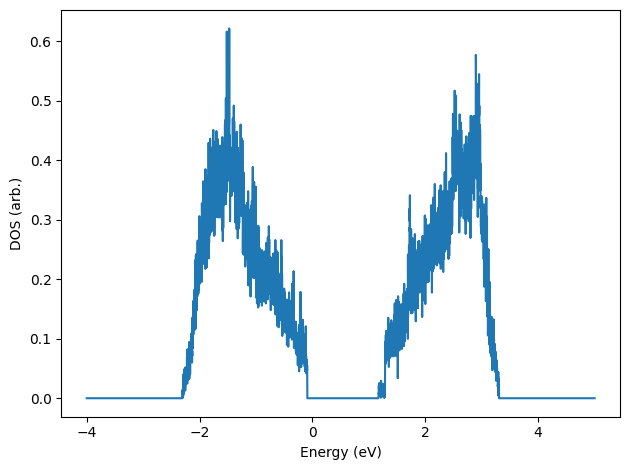

In [3]:

import os, multiprocessing as mp
os.environ.setdefault("OMP_NUM_THREADS", "1")   
os.environ.setdefault("MKL_NUM_THREADS", "1")   
mp.set_start_method("spawn", force=True)        #


import numpy as np
from joblib import Parallel, delayed
from scipy.stats import norm     
import time

Nk = 300
kx_fracs = np.linspace(-1.0, 1.0, Nk, dtype=np.float64)
ky_fracs = np.linspace(-1.0, 1.0, Nk, dtype=np.float64)

kmesh = np.stack(np.meshgrid(kx_fracs, ky_fracs, indexing="ij"),
                 axis=-1).reshape(-1, 2)
def solve_one(kvec):
    return TB.create_tight_binding_sparse(kvec) 

t0 = time.perf_counter()

results = Parallel(n_jobs=-1,             
                   prefer="processes",    
                   batch_size=64,          
                   verbose=10               
                   )(delayed(solve_one)(k) for k in kmesh)

wall = time.perf_counter() - t0
print(f"\nSweep finished in {wall:5.1f} s")


evals3d = np.stack([r[0] for r in results], axis=0).reshape(Nk, Nk, -1)
waves   = [r[1] for r in results]     


def get_dos_vec(energies, *, elow=-4, ehigh=5,
                broadening=0.0005, npoints=5000):
    points = np.linspace(elow, ehigh, npoints, dtype=np.float64)
    z = (points[:, None] - energies[None, :]) / broadening
    pref = 1.0 / (np.sqrt(2.0*np.pi) * broadening)
    evaluated = np.sum(pref * np.exp(-0.5*z*z),axis=1)
    
    return points, evaluated / len(energies)

points, dos = get_dos_vec(evals3d.ravel())
print("DOS computed ", points.shape)


if __name__ == "__main__":
    import matplotlib.pyplot as plt
    plt.plot(points, dos)
    plt.xlabel("Energy (eV)")
    plt.ylabel("DOS (arb.)")
    plt.tight_layout(); plt.show()


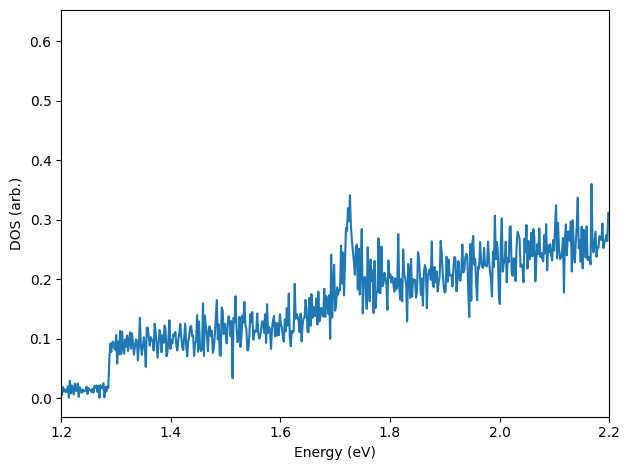

In [4]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    plt.plot(points, dos)
    plt.xlabel("Energy (eV)")
    plt.xlim(1.2,2.2)
    
    plt.ylabel("DOS (arb.)")
    plt.tight_layout(); plt.show()

In [ ]:

epsilon = 2.0        
t       = 0.5        
a       = 1.0       
T       = 300       
kbT     = spc.Boltzmann * T / spc.elementary_charge

elow, ehigh = -3.0, 10.0       
npoints     = 1001
E = np.linspace(elow, ehigh, npoints, dtype=np.float64) 

def one_d_dos(E, ep=epsilon, t=t):
    z = (ep - E) / (2*t)
    d = np.zeros_like(E)
    
    d = 1/np.pi / t / np.sqrt(1 - z**2)
    return d

E, dos = points, dos

h      = E[1] - E[0]
w      = np.full_like(E, h)
w[0]   = w[-1] = 0.5*h      
dw     = dos * w                


def fermi_fd(E, Ef, kbT=kbT):
    return 1.0 / (1.0 + np.exp((E - Ef)/kbT))

def electrons(Ef):
    return np.dot(dw, fermi_fd(E, Ef)) * (5.431e-10)**2 / spc.elementary_charge

def fermi_energy(target_N, tol=1e-10, max_iter=1000):
 
    lo, hi = E[0], E[-1]
    if electrons(lo) > target_N or electrons(hi) < target_N:
        raise ValueError("Target electron count lies outside the integration range.")

    for _ in range(max_iter):
        mid = 0.5*(lo + hi)
        err = electrons(mid)  - target_N
        if abs(err) < tol:
            return mid
        if err > 0:
            hi = mid
        else:
            lo = mid

        
    return mid  



Ef = fermi_energy(target_N=1)

print(f"Half‑filled Fermi energy  Ef = {Ef:.6f} eV")

Half‑filled Fermi energy  Ef = 1.526051 eV


In [ ]:
electrons(1.5)

np.float64(1.0015995297416609)